<a href="https://colab.research.google.com/github/Buttermint69/S2EF/blob/main/Data_prerprocessing_and_graphvis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.7.1+cu110 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install demjson==2.2.4 lmdb==1.1.1 ase==3.21 pymatgen==2020.12.31 pyyaml==5.4 tensorboard==2.4 wandb==0.11.2
!pip install torch-scatter==2.0.6 torch-sparse==0.6.9 torch-cluster==1.5.9 torch-spline-conv==1.2.1 torch-geometric==1.6.3 -f https://data.pyg.org/whl/torch-1.7.1+cu110.html
!pip install pysmiles
!pip install networkx

In [ ]:
import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
import ase.db.sqlite
import ase.io.trajectory
import numpy as np
import torch
from torch_geometric.data import Data
from itertools import product
import os
from ase.io import extxyz
from google.colab import drive
from pysmiles import read_smiles
import networkx as nx

drive.mount("/content/drive")
#from ocpmodels.common.utils import collate

try:
    from pymatgen.io.ase import AseAtomsAdaptor
except Exception:
    pass


try:
    shell = get_ipython().__class__.__name__
    if shell == "ZMQInteractiveShell":
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm
except NameError:
    from tqdm import tqdm

In [ ]:
def collate(data_list):
    keys = data_list[0].keys
    data = data_list[0].__class__()

    for key in keys:
        data[key] = []
    slices = {key: [0] for key in keys}

    for item, key in product(data_list, keys):
        data[key].append(item[key])
        if torch.is_tensor(item[key]):
            s = slices[key][-1] + item[key].size(
                item.__cat_dim__(key, item[key])
            )
        elif isinstance(item[key], int) or isinstance(item[key], float):
            s = slices[key][-1] + 1
        else:
            raise ValueError("Unsupported attribute type")
        slices[key].append(s)

    if hasattr(data_list[0], "__num_nodes__"):
        data.__num_nodes__ = []
        for item in data_list:
            data.__num_nodes__.append(item.num_nodes)

    for key in keys:
        if torch.is_tensor(data_list[0][key]):
            data[key] = torch.cat(
                data[key], dim=data.__cat_dim__(key, data_list[0][key])
            )
        else:
            data[key] = torch.tensor(data[key])
        slices[key] = torch.tensor(slices[key], dtype=torch.long)

    return data, slices

def adjncy(Data_obj):
  sys_dim = Data_obj.natoms
  neigh_idx = Data_obj.edge_index[0]
  source_idx = Data_obj.edge_index[1]
  zeros = torch.zeros(sys_dim, sys_dim)
  for i in range(len(source_idx)):
    zeros[source_idx[i], neigh_idx[i]] = 1
  return zeros

class AtomsToGraphs:
    """A class to help convert periodic atomic structures to graphs.

    The AtomsToGraphs class takes in periodic atomic structures in form of ASE atoms objects and converts
    them into graph representations for use in PyTorch. The primary purpose of this class is to determine the
    nearest neighbors within some radius around each individual atom, taking into account PBC, and set the
    pair index and distance between atom pairs appropriately. Lastly, atomic properties and the graph information
    are put into a PyTorch geometric data object for use with PyTorch.

    Args:
        max_neigh (int): Maximum number of neighbors to consider.
        radius (int or float): Cutoff radius in Angstroms to search for neighbors.
        r_energy (bool): Return the energy with other properties. Default is False, so the energy will not be returned.
        r_forces (bool): Return the forces with other properties. Default is False, so the forces will not be returned.
        r_distances (bool): Return the distances with other properties.
        Default is False, so the distances will not be returned.
        r_fixed (bool): Return a binary vector with flags for fixed (1) vs free (0) atoms.
        Default is True, so the fixed indices will be returned.

    Attributes:
        max_neigh (int): Maximum number of neighbors to consider.
        radius (int or float): Cutoff radius in Angstoms to search for neighbors.
        r_energy (bool): Return the energy with other properties. Default is False, so the energy will not be returned.
        r_forces (bool): Return the forces with other properties. Default is False, so the forces will not be returned.
        r_distances (bool): Return the distances with other properties.
        Default is False, so the distances will not be returned.
        r_fixed (bool): Return a binary vector with flags for fixed (1) vs free (0) atoms.
        Default is True, so the fixed indices will be returned.

    """

    def __init__(
        self,
        max_neigh=200,
        radius=6,
        r_energy=False,
        r_forces=False,
        r_distances=False,
        r_edges=True,
        r_fixed=True,
    ):
        self.max_neigh = max_neigh
        self.radius = radius
        self.r_energy = r_energy
        self.r_forces = r_forces
        self.r_distances = r_distances
        self.r_fixed = r_fixed
        self.r_edges = r_edges

    def _get_neighbors_pymatgen(self, atoms):
        """Preforms nearest neighbor search and returns edge index, distances,
        and cell offsets"""
        struct = AseAtomsAdaptor.get_structure(atoms)
        _c_index, _n_index, _offsets, n_distance = struct.get_neighbor_list(
            r=self.radius, numerical_tol=0, exclude_self=True
        )

        _nonmax_idx = []
        for i in range(len(atoms)):
            idx_i = (_c_index == i).nonzero()[0]
            # sort neighbors by distance, remove edges larger than max_neighbors
            idx_sorted = np.argsort(n_distance[idx_i])[: self.max_neigh]
            _nonmax_idx.append(idx_i[idx_sorted])
        _nonmax_idx = np.concatenate(_nonmax_idx)

        _c_index = _c_index[_nonmax_idx]
        _n_index = _n_index[_nonmax_idx]
        n_distance = n_distance[_nonmax_idx]
        _offsets = _offsets[_nonmax_idx]

        return _c_index, _n_index, n_distance, _offsets

    def _reshape_features(self, c_index, n_index, n_distance, offsets):
        """Stack center and neighbor index and reshapes distances,
        takes in np.arrays and returns torch tensors"""
        edge_index = torch.LongTensor(np.vstack((n_index, c_index)))
        edge_distances = torch.FloatTensor(n_distance)
        cell_offsets = torch.LongTensor(offsets)

        # remove distances smaller than a tolerance ~ 0. The small tolerance is
        # needed to correct for pymatgen's neighbor_list returning self atoms
        # in a few edge cases.
        nonzero = torch.where(edge_distances >= 1e-8)[0]
        edge_index = edge_index[:, nonzero]
        edge_distances = edge_distances[nonzero]
        cell_offsets = cell_offsets[nonzero]

        return edge_index, edge_distances, cell_offsets

    def convert(
        self,
        atoms,
    ):
        """Convert a single atomic stucture to a graph.

        Args:
            atoms (ase.atoms.Atoms): An ASE atoms object.

        Returns:
            data (torch_geometric.data.Data): A torch geometic data object with edge_index, positions, atomic_numbers,
            and optionally, energy, forces, and distances.
            Optional properties can included by setting r_property=True when constructing the class.
        """

        # set the atomic numbers, positions, and cell
        atomic_numbers = torch.Tensor(atoms.get_atomic_numbers())
        positions = torch.Tensor(atoms.get_positions())
        cell = torch.Tensor(atoms.get_cell()).view(1, 3, 3)
        natoms = positions.shape[0]

        # put the minimum data in torch geometric data object
        data = Data(
            cell=cell,
            pos=positions,
            atomic_numbers=atomic_numbers,
            natoms=natoms,
        )

        # optionally include other properties
        if self.r_edges:
            # run internal functions to get padded indices and distances
            split_idx_dist = self._get_neighbors_pymatgen(atoms)
            edge_index, edge_distances, cell_offsets = self._reshape_features(
                *split_idx_dist
            )

            data.edge_index = edge_index
            data.cell_offsets = cell_offsets
        if self.r_energy:
            energy = atoms.get_potential_energy(apply_constraint=False)
            data.y = energy
        if self.r_forces:
            forces = torch.Tensor(atoms.get_forces(apply_constraint=False))
            data.force = forces
        if self.r_distances and self.r_edges:
            data.distances = edge_distances
        if self.r_fixed:
            fixed_idx = torch.zeros(natoms)
            if hasattr(atoms, "constraints"):
                from ase.constraints import FixAtoms

                for constraint in atoms.constraints:
                    if isinstance(constraint, FixAtoms):
                        fixed_idx[constraint.index] = 1
            data.fixed = fixed_idx

        return data

    def convert_all(
        self,
        atoms_collection,
        processed_file_path=None,
        collate_and_save=False,
        disable_tqdm=False,
    ):
        """Convert all atoms objects in a list or in an ase.db to graphs.

        Args:
            atoms_collection (list of ase.atoms.Atoms or ase.db.sqlite.SQLite3Database):
            Either a list of ASE atoms objects or an ASE database.
            processed_file_path (str):
            A string of the path to where the processed file will be written. Default is None.
            collate_and_save (bool): A boolean to collate and save or not. Default is False, so will not write a file.

        Returns:
            data_list (list of torch_geometric.data.Data):
            A list of torch geometric data objects containing molecular graph info and properties.
        """

        # list for all data
        data_list = []
        if isinstance(atoms_collection, list):
            atoms_iter = atoms_collection
        elif isinstance(atoms_collection, ase.db.sqlite.SQLite3Database):
            atoms_iter = atoms_collection.select()
        elif isinstance(
            atoms_collection, ase.io.trajectory.SlicedTrajectory
        ) or isinstance(atoms_collection, ase.io.trajectory.TrajectoryReader):
            atoms_iter = atoms_collection
        else:
            raise NotImplementedError

        for atoms in tqdm(
            atoms_iter,
            desc="converting ASE atoms collection to graphs",
            total=len(atoms_collection),
            unit=" systems",
            disable=disable_tqdm,
        ):
            # check if atoms is an ASE Atoms object this for the ase.db case
            if not isinstance(atoms, ase.atoms.Atoms):
                atoms = atoms.toatoms()
            data = self.convert(atoms)
            data_list.append(data)

        if collate_and_save:
            data, slices = collate(data_list)
            torch.save((data, slices), processed_file_path)

        return data_list

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_data = ase.io.read("/content/drive/My Drive/OCP_prac/ocp_data/CuCO_adslab.extxyz", ":")
#conv_2_extxy(raw_data, file_name = "CuCO_adslab.extxyz" )
print(raw_data[0])

Atoms(symbols='Cu12OC', pbc=True, cell=[5.105310960166873, 5.105310960166873, 32.61], energies=..., forces=..., tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3]), calculator=SinglePointCalculator(...))


In [ ]:
a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=True,
    r_forces=True,
    r_distances=False,
    r_edges=True,
    r_fixed=True,
)
data_objects = a2g.convert_all(raw_data, disable_tqdm=True)
data = data_objects[0]
print(data)

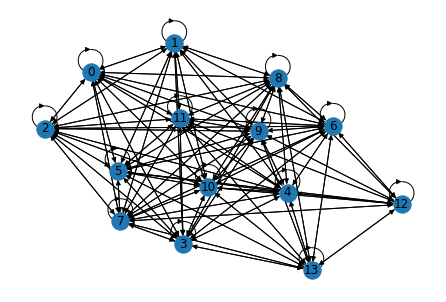

In [ ]:
from torch_geometric.utils import to_networkx 
g_ = to_networkx(data)

node_ = list(g_.nodes())
ls =  list(ase.symbols.Symbols(data.atomic_numbers))
mappings = dict()
counter = dict()
for i in range(0,len(ls)):
  if ls[i] in counter.keys():

    counter[ls[i]] +=1
    mappings[i] = str(ls[i]) + str(counter[ls[i]])

  else:
    counter[ls[i]] = 0
    mappings[i] = str(ls[i]) + str(counter[ls[i]])


nx.draw(g_, with_labels= True)

h = nx.relabel_nodes(g_, mapping = mappings)
nx.draw(h, with_labels = True)

# Train data2Graph

In [ ]:
loc = "/content/drive/My Drive/OCP_prac/s2ef_train_200K/0.extxyz"

In [ ]:
data_0 = ase.io.read(loc, ":")
data_0[0]

Atoms(symbols='C2H4Ag16Ca32Cu16O', pbc=True, cell=[[9.18446134, 0.0, 0.0], [0.0, 22.63986204, -4.15391219], [0.0, 0.0, 29.07738533]], forces=..., tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 29, 30, 32, 33, 34, 35, 36, 38, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 63]), calculator=SinglePointCalculator(...))

In [ ]:
print(data_0[0].get_tags())

[0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 2 2 2 2 2 2 2]


In [ ]:
a2g_ = AtomsToGraphs(
    max_neigh=71,
    radius=6,
    r_energy=True,
    r_forces=True,
    r_distances=False,
    r_edges=True,
    r_fixed=True,
)
len(data_0[0].get_atomic_numbers())
#data_0[0].get_atomic_numbers()

71

In [ ]:
data_objects_ = a2g_.convert_all(data_0, disable_tqdm=True)

In [ ]:
data_objects_0 = data_objects_[0]
data_objects_0

Data(atomic_numbers=[71], cell=[1, 3, 3], cell_offsets=[1726, 3], edge_index=[2, 1726], fixed=[71], force=[71, 3], natoms=71, pos=[71, 3], y=-181.54722937)

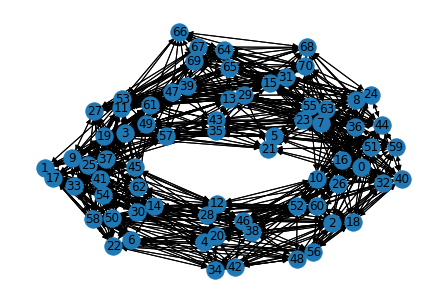

In [ ]:
g_2k = to_networkx(data_objects_0)
nx.draw(g_2k, with_labels= True)

In [ ]:
for i in data_objects_0.edge_index:
  print(i)

tensor([55, 51, 40,  ..., 23,  7, 61])
tensor([ 0,  0,  0,  ..., 70, 70, 70])
